In [1]:
import os
import keras

from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input #224*224
from keras import Model, optimizers, models, layers, Input
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
print(f"the keras version is : {keras.__version__} (important to load model from h5 file)")

the keras version is : 2.4.3 (important to load model from h5 file)


In [2]:
################################################
# DATASET
################################################

data_folder = "d:/work/emotions"

def analyze_dataset(subfolder):
    print(f"{subfolder} dataset")
    full_folder_path = data_folder +"/"+ subfolder +"/"
    for expression in os.listdir(full_folder_path):
        print("\t" + str(len(os.listdir(full_folder_path + expression))) + " " + expression + " images")
    print("\n")
    return full_folder_path

train_folder = analyze_dataset("train")
valid_folder = analyze_dataset("valid")

###################################
# 
img_shape = (48, 48)
batch_size = 64

train_img_generator = ImageDataGenerator(horizontal_flip=True)
valid_img_generator = ImageDataGenerator(horizontal_flip=True)

train_generator = train_img_generator.flow_from_directory(train_folder,
                                                    target_size=img_shape,
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


valid_generator = valid_img_generator.flow_from_directory(valid_folder,
                                                    target_size=img_shape,
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)


train dataset
	3995 angry images
	436 disgust images
	4097 fear images
	7214 happy images
	4965 neutral images
	4830 sad images
	3171 surprise images


valid dataset
	958 angry images
	111 disgust images
	1024 fear images
	1774 happy images
	1233 neutral images
	1247 sad images
	831 surprise images


Found 28708 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
def get_model():
    mdl = Sequential()

    mdl.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
    mdl.add(BatchNormalization())
    mdl.add(Activation('relu'))
    mdl.add(MaxPooling2D(pool_size=(2, 2)))
    mdl.add(Dropout(0.25))

    mdl.add(Conv2D(128,(5,5), padding='same'))
    mdl.add(BatchNormalization())
    mdl.add(Activation('relu'))
    mdl.add(MaxPooling2D(pool_size=(2, 2)))
    mdl.add(Dropout(0.25))

    mdl.add(Conv2D(256,(3,3), padding='same'))
    mdl.add(BatchNormalization())
    mdl.add(Activation('relu'))
    mdl.add(MaxPooling2D(pool_size=(2, 2)))
    mdl.add(Dropout(0.25))

    mdl.add(Conv2D(512,(3,3), padding='same'))
    mdl.add(BatchNormalization())
    mdl.add(Activation('relu'))
    mdl.add(MaxPooling2D(pool_size=(2, 2)))
    mdl.add(Dropout(0.25))

    mdl.add(Flatten())

    mdl.add(Dense(256))
    mdl.add(BatchNormalization())
    mdl.add(Activation('relu'))
    mdl.add(Dropout(0.25))

    mdl.add(Dense(512))
    mdl.add(BatchNormalization())
    mdl.add(Activation('relu'))
    mdl.add(Dropout(0.25))

    mdl.add(Dense(7, activation='softmax'))

    opt = optimizers.Adam(lr=0.0005)
    mdl.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return mdl

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [5]:
epochs = 15
train_steps = train_generator.n // train_generator.batch_size
valid_steps = valid_generator.n // valid_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data = valid_generator,
    validation_steps = valid_steps,
    callbacks=callbacks
)

Epoch 1/2
448/448 [==============================] - 572s 1s/step - loss: 1.6542 - accuracy: 0.3622 - val_loss: 1.6039 - val_accuracy: 0.3856
Epoch 2/2
448/448 [==============================] - 568s 1s/step - loss: 1.4314 - accuracy: 0.4516 - val_loss: 1.3555 - val_accuracy: 0.4760


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


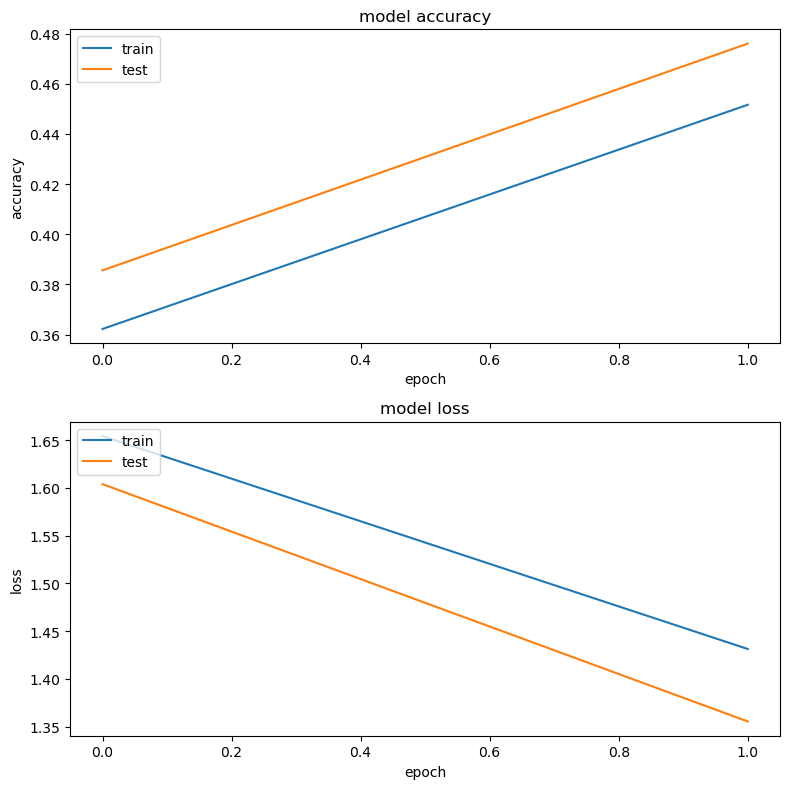

In [6]:
import matplotlib.pyplot as plt

def plot_history(history):
    # list all data in history
    print(history.history.keys())

    fig = plt.figure(figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
    plt.subplot(2, 1, 1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(2, 1, 2)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    fig.tight_layout()
    plt.show()
    
plot_history(history)

In [8]:
import tensorflow as tf

# save h5
model.save("model.h5")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ffer\AppData\Local\Temp\tmprk4frdca\assets


INFO:tensorflow:Assets written to: C:\Users\ffer\AppData\Local\Temp\tmprk4frdca\assets


In [14]:
import datetime

test_img_generator = ImageDataGenerator(horizontal_flip=True)
test_generator = test_img_generator.flow_from_directory("d:/work/emotions/test",
                                                    target_size=img_shape,
                                                    color_mode="grayscale",
                                                    batch_size=10,
                                                    class_mode='categorical',
                                                    shuffle=True)

start = datetime.datetime.now() 
score = model.evaluate(test_generator)
end = datetime.datetime.now() 
print("Time= ",end-start)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Found 70 images belonging to 7 classes.
7/7 [==============================] - 0s 28ms/step - loss: 1.4619 - accuracy: 0.4143
Time=  0:00:00.255311
Test Loss: 1.4619269371032715
Test Accuracy: 0.41428571939468384


(48, 48, 1)
[[0.05496354 0.01318404 0.08862437 0.45900297 0.10588294 0.2457997
  0.03254247]]
happy


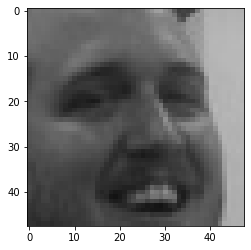

In [23]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

image_path = "d:\\work\\emotions\\train\\happy\\Training_10116721.jpg"
# img = image.load_img(image_path, target_size=(48,48))
img = cv2.imread(image_path)
x = image.img_to_array(img)
x = rgb2gray(x).reshape(48, 48, 1)
print(x.shape)
x = np.expand_dims(x, axis=0)
predictions = model.predict(x)
print(predictions)

emotion_labels = ["angry","disgust","fear","happy","neutral","sad","surprise"]

print(emotion_labels[np.argmax(predictions)])
plt.imshow(img)

In [26]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 64
epochs = 4
 
num_images = 2000
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs


pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.0, final_sparsity=0.60, begin_step=0, end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)


model_for_pruning.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

model_for_pruning.summary()

D:\Perso\UMons\Anaconda\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 48, 48, 64)        1218      
_________________________________________________________________
prune_low_magnitude_batch_no (None, 48, 48, 64)        257       
_________________________________________________________________
prune_low_magnitude_activati (None, 48, 48, 64)        1         
_________________________________________________________________
prune_low_magnitude_max_pool (None, 24, 24, 64)        1         
_________________________________________________________________
prune_low_magnitude_dropout  (None, 24, 24, 64)        1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 24, 24, 128)       409730    
_________________________________________________________________
prune_low_magnitude_batch_no (None, 24, 24, 128)       5